# GRU Quantílico (Soma das Próximas 4 Semanas, com Incerteza)

Este notebook implementa o modelo GRU quantílico para previsão da **soma das próximas 4 semanas** (previsão mensal) das taxas de morbidade respiratória em municípios brasileiros, incluindo intervalos de incerteza.

- **Modelo:** GRU Quantílico
- **Alvo:** Soma das próximas 4 semanas (previsão mensal)
- **Input:** sequência de 24 semanas (shape: [batch, 24, 1])
- **Arquitetura:** GRU(64) → Dense(3) (previsão dos quantis p10, p50 e p90)
- **Perda:** Quantile loss (customizada)
- **Métrica:** cobertura dos intervalos, pinball loss
- **Todo o código é modular e importado dos módulos `src/`.**

In [1]:
import sys
import os

# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(f"Project root: {project_root}")

# Add the project root to sys.path (not the src directory)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to sys.path")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from src.preprocessing import load_city_data, prepare_data_for_model, filter_city, clean_timeseries
from src.models import build_quantile_gru
from src.train import train_model, evaluate_model, generate_forecasts, save_predictions, save_metrics
from src.utils import plot_forecast, plot_forecast_error, plot_training_history

results_dir = os.path.join('results', 'gru_quantile')
os.makedirs(results_dir, exist_ok=True)

np.random.seed(42)

Project root: c:\Users\pedro\OneDrive - Unesp\Documentos\GitHub\cities-models\cities-models
Added c:\Users\pedro\OneDrive - Unesp\Documentos\GitHub\cities-models\cities-models to sys.path


## Estrutura do Repositório

- **data/**: Um CSV por cidade, cada um com coluna de data, coluna alvo e features opcionais.
- **notebooks/**: Notebooks para cada experimento. Apenas visualização e exploração.
- **src/**: Módulos reutilizáveis:
    - `preprocessing.py`: Carregamento, normalização, split, criação de janelas
    - `models.py`: Definições de modelos (baselines, MLP, GRU, etc.)
    - `train.py`: Rotinas de treino e avaliação
    - `utils.py`: Funções auxiliares (plot, métricas, etc.)
- **results/**: Previsões e métricas salvas.
- **instructions.md**: Guia de boas práticas.

**Toda a lógica central está em `src/`.**

## Carregamento e Exploração dos Dados

Carregue os dados de morbidade respiratória para análise. Você pode iterar sobre todas as cidades ou selecionar uma específica.

In [2]:
# Exemplo: Carregar dados de uma cidade (ajuste o caminho conforme necessário)
data_path = '../data/df_base_morb_resp.csv'
df = load_city_data(data_path)

print(f"Formato do dataset: {df.shape}")
df.head()

Formato do dataset: (6684000, 11)


,CD_MUN,week,target,PIB,DENS,URB,CO2,CH4,N2O,LAT,LON
0,1100015,0,0.515856,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
1,1100015,1,0.539765,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
2,1100015,2,0.458823,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
3,1100015,3,0.485555,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
4,1100015,4,0.231805,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39


In [3]:
print("Colunas disponíveis:")
print(df.columns.tolist())
df.describe()

Colunas disponíveis:
['CD_MUN', 'week', 'target', 'PIB', 'DENS', 'URB', 'CO2', 'CH4', 'N2O', 'LAT', 'LON']


,CD_MUN,week,target,PIB,DENS,URB,CO2,CH4,N2O,LAT,LON
count,6.684000e+06,6.684000e+06,6.684000e+06,6.003816e+06,6.033600e+06,6.033600e+06,6.033600e+06,6.033600e+06,6.033600e+06,6.033600e+06,6.033600e+06
mean,3.253591e+06,5.995000e+02,4.710729e-01,1.397299e+04,8.091379e+01,1.268524e-02,3.953797e+04,7.463403e+02,1.116126e+01,-1.638302e+01,-4.637996e+01
std,9.848220e+05,3.464101e+02,3.616928e+00,1.973538e+04,3.952444e+02,4.668693e-02,1.244388e+05,1.332048e+04,2.845796e+01,8.354524e+00,6.424812e+00
min,1.100015e+06,0.000000e+00,0.000000e+00,-1.459830e+03,3.143629e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.365254e+01,-7.348400e+01
25%,2.512101e+06,2.997500e+02,0.000000e+00,4.516650e+03,1.112562e+01,1.319166e-03,4.454221e+03,6.922971e+01,4.712564e+00,-2.279264e+01,-5.102275e+01
50%,3.146280e+06,5.995000e+02,0.000000e+00,8.607535e+03,2.363456e+01,2.999792e-03,1.128696e+04,1.379897e+02,8.660524e+00,-1.785337e+01,-4.661550e+01
75%,4.119202e+06,8.992500e+02,2.773210e-01,1.684539e+04,4.817254e+01,7.148583e-03,2.817704e+04,2.405503e+02,1.352129e+01,-8.456431e+00,-4.166000e+01
max,5.300108e+06,1.199000e+03,7.359496e+02,9.208340e+05,1.344249e+04,9.768962e-01,3.137265e+06,7.075641e+05,3.683565e+03,4.685425e+00,-3.487000e+01


## Seleção e Limpeza de Dados

Selecione a cidade para modelagem e limpe a série temporal.

In [4]:
# Select city for modeling (set to None to use all cities)
CD_MUN_SELECTED = 3550308  # São Paulo

df_city = filter_city(df, cd_mun=CD_MUN_SELECTED)
df_city = clean_timeseries(df_city, target_column='target')
print(f"Selected city shape: {df_city.shape}")

Selected city shape: (1200, 11)


## Pré-processamento

Prepare os dados para o modelo GRU quantílico. O input é uma sequência de 24 semanas.

In [5]:
model_params = {
    'sequence_length': 12,
    'forecast_horizon': 4,  # Soma das próximas 4 semanas (previsão mensal)
    'normalization': 'zscore',
    'val_size': None
}
target_column = 'target'

data_dict = prepare_data_for_model(
    df=df_city,
    target_column=target_column,
    sequence_length=model_params['sequence_length'],
    forecast_horizon=model_params['forecast_horizon'],
    normalization=model_params['normalization'],
    val_size=model_params.get('val_size', None)
)

X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict.get('X_val', None)
y_val = data_dict.get('y_val', None)
X_test = data_dict['X_test']
y_test = data_dict['y_test']
test_df = data_dict['test_df']
scaler = data_dict.get('scaler')
feature_columns = data_dict.get('feature_columns', None)

## Definição e Treinamento do Modelo

O modelo GRU quantílico utiliza uma camada GRU com 64 unidades e uma camada densa de saída para 3 quantis.

In [6]:
input_shape = X_train.shape[1:]
model = build_quantile_gru(input_shape=input_shape, quantiles=[0.1, 0.5, 0.9])

history = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    batch_size=32,
    epochs=300,
    patience=30,
    verbose=1
)

Epoch 1/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0767 - val_loss: 0.9722 - learning_rate: 0.0010
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0767 - val_loss: 0.9722 - learning_rate: 0.0010
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6593 - val_loss: 0.7281 - learning_rate: 0.0010
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6593 - val_loss: 0.7281 - learning_rate: 0.0010
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4665 - val_loss: 0.6540 - learning_rate: 0.0010
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4665 - val_loss: 0.6540 - learning_rate: 0.0010
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4624 - val_loss: 0.6356 - learning_rate: 0.0010
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4624 - val_loss: 0.6356 - learning_rate: 0.0010
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4067 - val_loss: 0.6209 - learning_rate: 0.0010
Epoch 6/300
32/32

## Avaliação do Modelo

Calcule MAE, RMSE, R², pinball loss e cobertura dos intervalos para o modelo GRU quantílico.

In [11]:
metrics = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler
)

print("Métricas de Avaliação:")
print(f"MAE: {metrics['mae']:.4f}")
print(f"RMSE: {metrics['rmse']:.4f}")
print(f"R²: {metrics['r2']:.4f}")
print(f"Pinball Loss: {metrics.get('pinball_loss', float('nan')):.4f}")
print(f"Cobertura Intervalar: {metrics.get('coverage', float('nan')):.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Métricas de Avaliação:
MAE: 322.2004
RMSE: 357.5483
R²: -10.7225
Pinball Loss: nan
Cobertura Intervalar: nan


## Visualização dos Resultados

Plote os valores reais versus previstos (quantis) e o erro de previsão. O alvo é a **soma das próximas 4 semanas** (previsão mensal).

In [12]:
def reduce_to_1d(arr):
    arr = np.asarray(arr)
    if arr.ndim == 1:
        return arr
    if arr.ndim == 2:
        if arr.shape[1] == 1:
            return arr.ravel()
        else:
            return arr.sum(axis=1)
    raise ValueError(f"Unexpected array shape: {arr.shape}")

# Always define robust 1D, denormalized arrays for all plots and DataFrames
y_test_1d = reduce_to_1d(y_test)
y_pred = generate_forecasts(model, X_test)
y_pred_1d = reduce_to_1d(y_pred)
if scaler is not None and hasattr(scaler, 'scale_') and hasattr(scaler, 'mean_'):
    if scaler.scale_.shape[0] > 1:
        y_test_1d = y_test_1d * scaler.scale_[0] + scaler.mean_[0]
        y_pred_1d = y_pred_1d * scaler.scale_[0] + scaler.mean_[0]
    else:
        y_test_1d = scaler.inverse_transform(y_test_1d.reshape(-1, 1)).flatten()
        y_pred_1d = scaler.inverse_transform(y_pred_1d.reshape(-1, 1)).flatten()

test_dates = test_df['week'].values[-len(y_test_1d):] if 'week' in test_df.columns else np.arange(len(y_test_1d))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


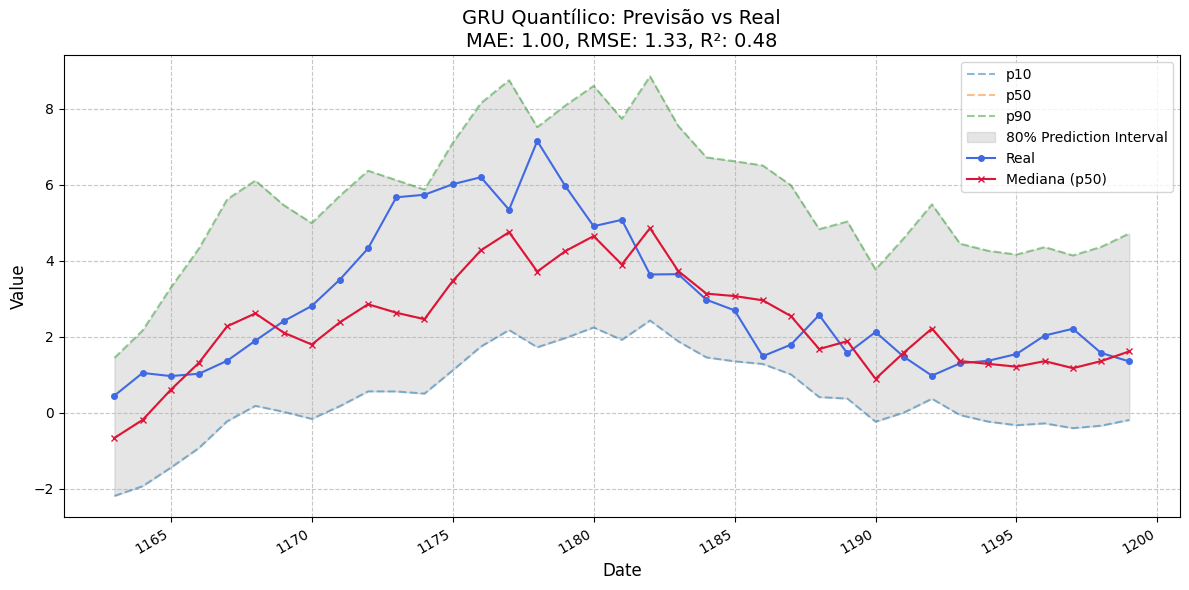

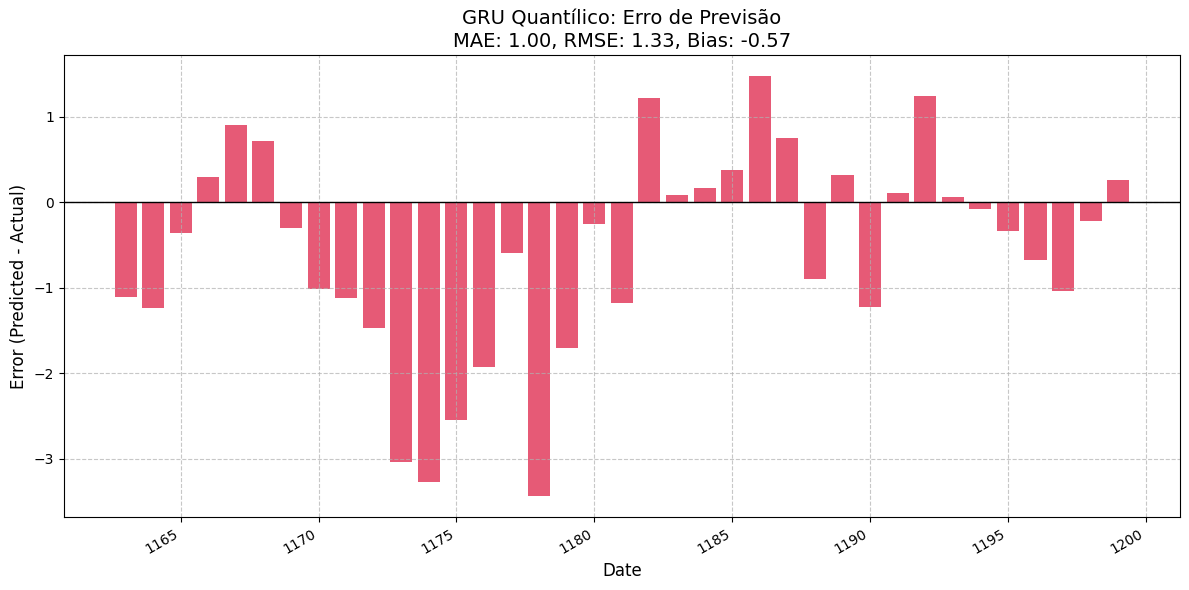

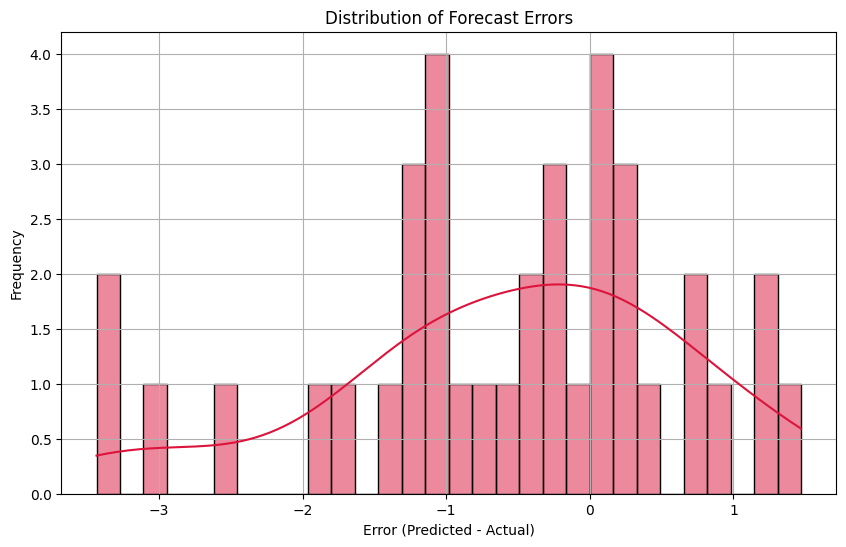

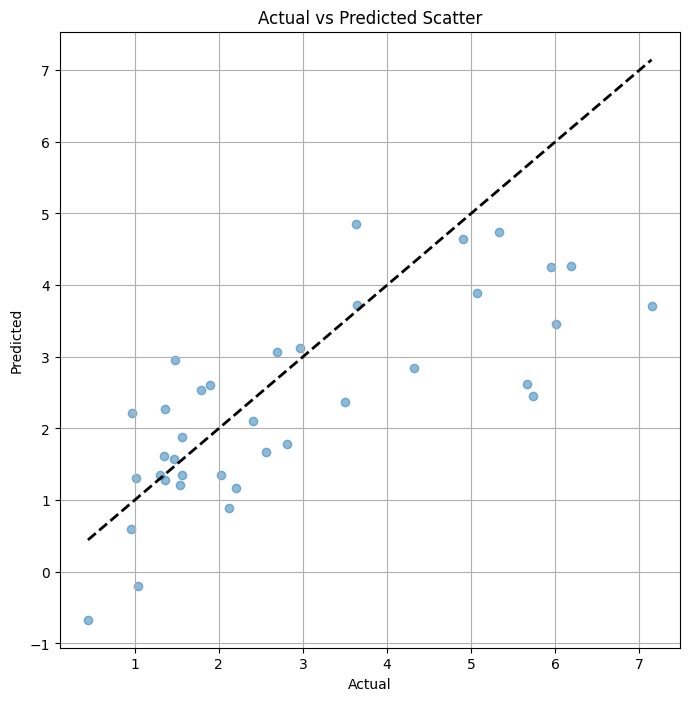

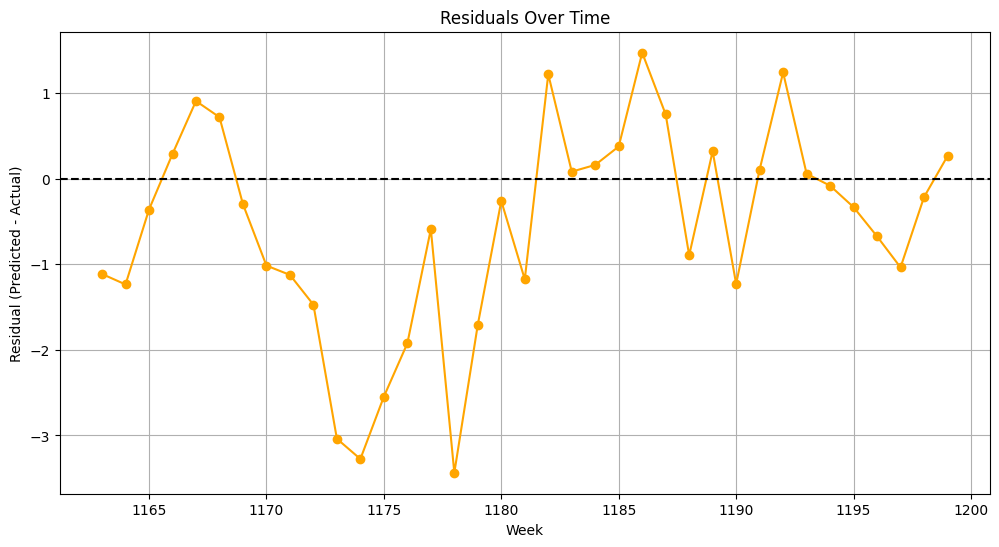

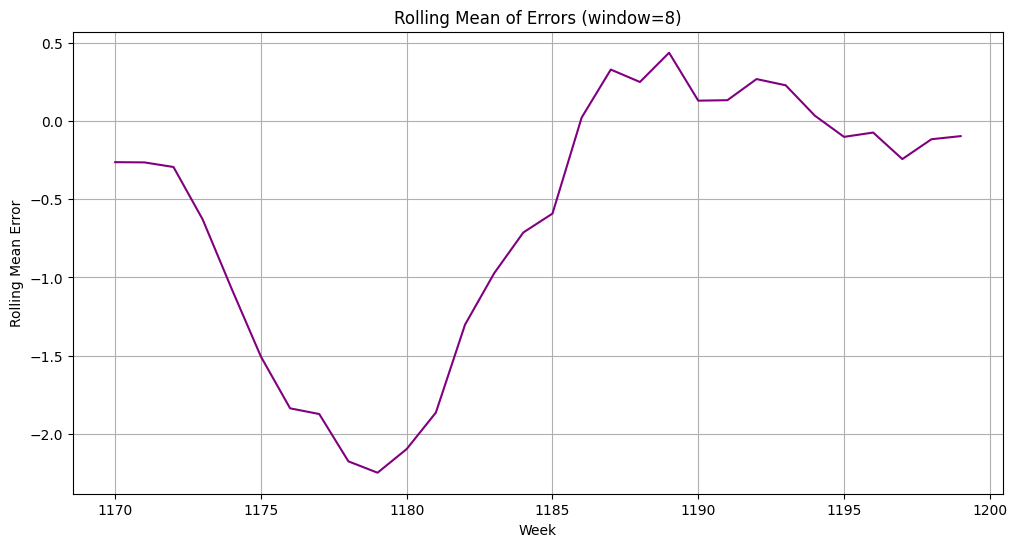

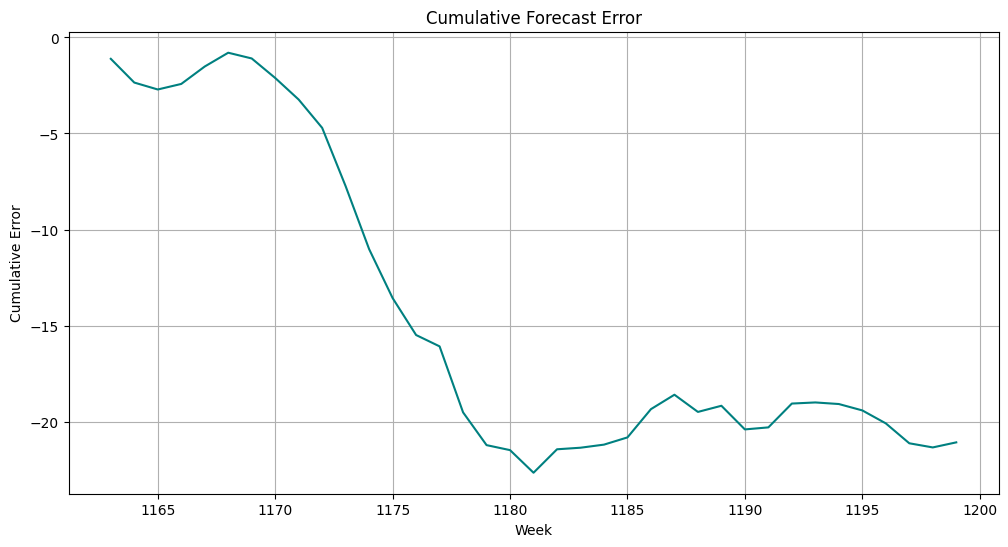

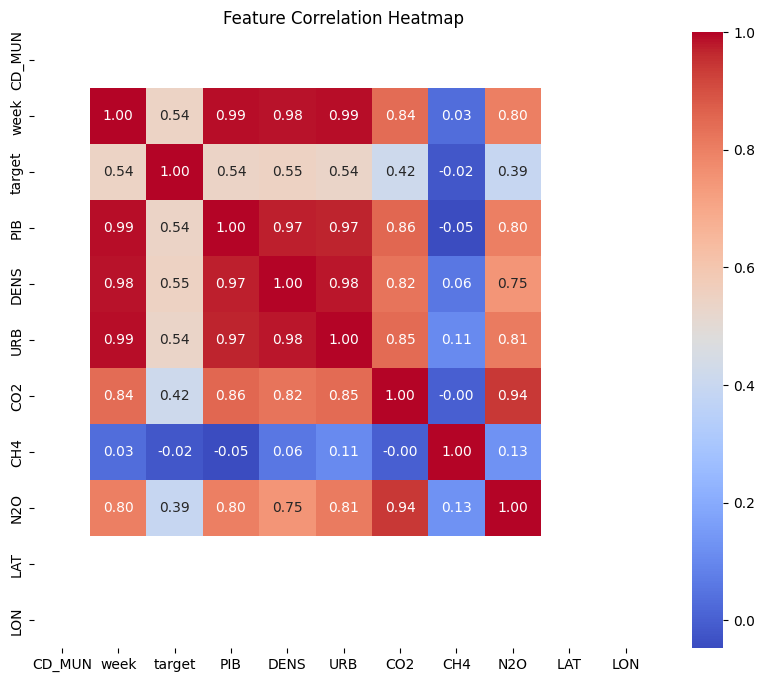

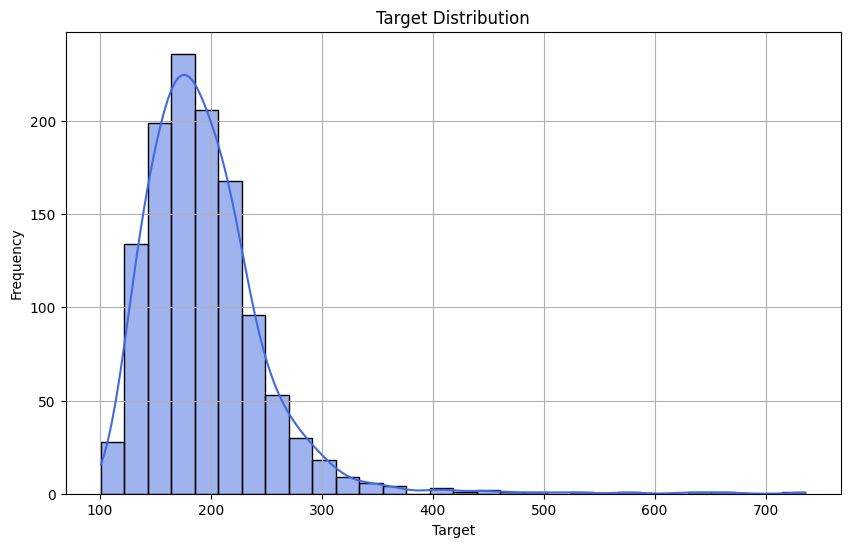

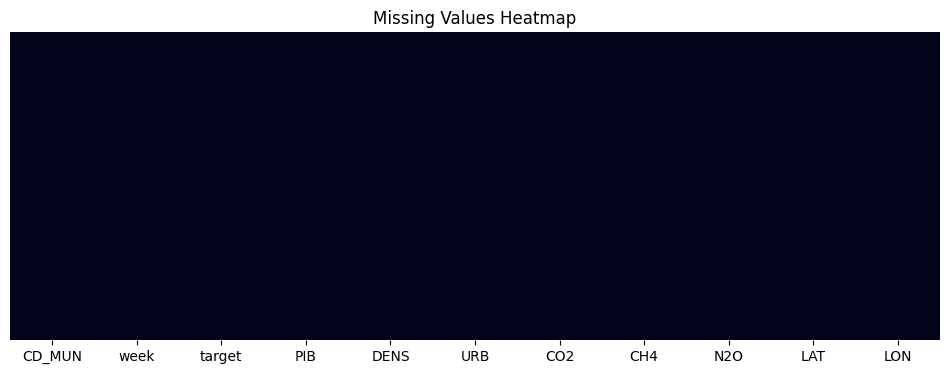

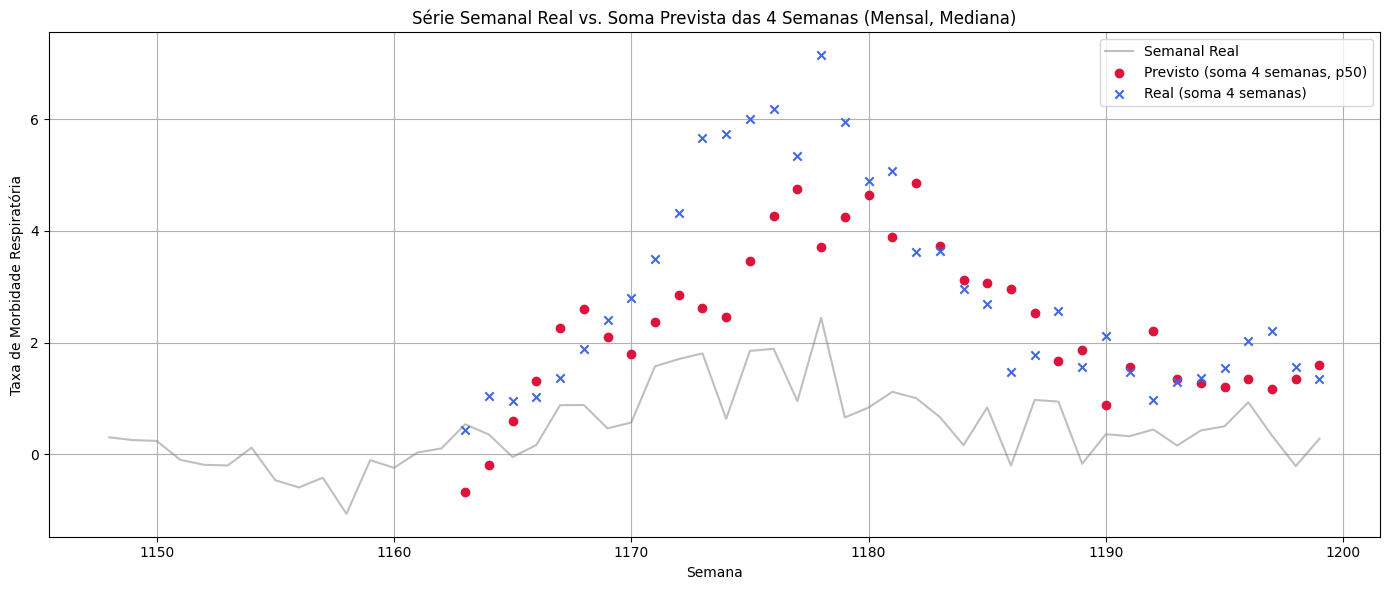

,week,y_test (soma 4 sem),"y_pred (soma 4 sem, p50)"
0,1163,0.444002,-0.669677
1,1164,1.041154,-0.194559
2,1165,0.958905,0.598495
3,1166,1.020973,1.309831
4,1167,1.362383,2.269253
5,1168,1.890195,2.608002
6,1169,2.402830,2.104338
7,1170,2.804488,1.788915
8,1171,3.499386,2.375232
9,1172,4.321434,2.849271


In [14]:
# Get time axis for the test set
# Use 'week' if available, else integer index
if 'week' in test_df.columns:
    test_dates = test_df['week'].values[-len(y_test):]
else:
    test_dates = np.arange(len(y_test))

# Previsões (quantis)
y_pred = generate_forecasts(model, X_test)

# y_pred deve ser shape (n, 3) para p10, p50, p90
quantiles = {'p10': y_pred[:,0], 'p50': y_pred[:,1], 'p90': y_pred[:,2]}

fig = plot_forecast(
    true_values=y_test,
    predictions=quantiles['p50'],
    dates=test_dates,
    title="GRU Quantílico: Previsão vs Real",
    true_label="Real",
    pred_label="Mediana (p50)",
    quantiles=quantiles
)
plt.savefig(os.path.join(results_dir, 'forecast_plot.png'))
plt.show()

fig = plot_forecast_error(
    true_values=y_test,
    predictions=quantiles['p50'],
    dates=test_dates,
    title="GRU Quantílico: Erro de Previsão"
)
plt.savefig(os.path.join(results_dir, 'error_plot.png'))
plt.show()

# --- Advanced Evaluation and Visualization ---

# 1. Distribution of Errors
errors = quantiles['p50'] - y_test
plt.figure(figsize=(10,6))
sns.histplot(errors, kde=True, bins=30, color='crimson')
plt.title('Distribution of Forecast Errors')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8,8))
plt.scatter(y_test, quantiles['p50'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Scatter')
plt.grid(True)
plt.show()

# 3. Residuals Over Time
plt.figure(figsize=(12,6))
plt.plot(test_dates, errors, marker='o', linestyle='-', color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Week')
plt.ylabel('Residual (Predicted - Actual)')
plt.grid(True)
plt.show()

# 4. Rolling Mean of Errors
window = 8
rolling_error = pd.Series(errors).rolling(window=window).mean()
plt.figure(figsize=(12,6))
plt.plot(test_dates, rolling_error, color='purple')
plt.title(f'Rolling Mean of Errors (window={window})')
plt.xlabel('Week')
plt.ylabel('Rolling Mean Error')
plt.grid(True)
plt.show()

# 5. Cumulative Error
cumulative_error = np.cumsum(errors)
plt.figure(figsize=(12,6))
plt.plot(test_dates, cumulative_error, color='teal')
plt.title('Cumulative Forecast Error')
plt.xlabel('Week')
plt.ylabel('Cumulative Error')
plt.grid(True)
plt.show()

# 6. Feature Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_city.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# 7. Target Distribution
plt.figure(figsize=(10,6))
sns.histplot(df_city['target'], kde=True, bins=30, color='royalblue')
plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 8. Missing Values Heatmap
plt.figure(figsize=(12,4))
sns.heatmap(df_city.isnull(), cbar=False, yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

# Overlay plot: Série semanal real e soma prevista das 4 semanas (mediana)
plt.figure(figsize=(14,6))
plt.plot(test_df['week'], test_df['target'], label='Semanal Real', color='gray', alpha=0.5)
plt.scatter(test_df['week'].values[-len(quantiles['p50']):], quantiles['p50'], label='Previsto (soma 4 semanas, p50)', color='crimson', zorder=3)
plt.scatter(test_df['week'].values[-len(y_test):], y_test, label='Real (soma 4 semanas)', color='royalblue', marker='x', zorder=3)
plt.title('Série Semanal Real vs. Soma Prevista das 4 Semanas (Mensal, Mediana)')
plt.xlabel('Semana')
plt.ylabel('Taxa de Morbidade Respiratória')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Diagnóstico: Verificar alinhamento de y_test e y_pred (p50)
import pandas as pd
N = 10
week_idx = test_df['week'].values[-len(y_test):]
df_diag = pd.DataFrame({
    'week': week_idx[:N],
    'y_test (soma 4 sem)': y_test[:N],
    'y_pred (soma 4 sem, p50)': quantiles['p50'][:N]
})
display(df_diag)

## Salvar Resultados

Salve as previsões e métricas para comparação posterior.

In [15]:
# Salvar previsões
preds_file = save_predictions(
    y_true=y_test,
    y_pred=quantiles['p50'],
    dates=test_dates,
    city_name='all',
    model_name='gru_quantile',
    output_dir=results_dir
)
print(f"Previsões salvas em: {preds_file}")

# Salvar métricas
metrics_file = save_metrics(
    metrics=metrics,
    city_name='all',
    model_name='gru_quantile',
    output_dir=results_dir,
    params=model_params
)
print(f"Métricas salvas em: {metrics_file}")

Previsões salvas em: results\gru_quantile\all_gru_quantile_preds.csv
Métricas salvas em: results\gru_quantile\all_gru_quantile_metrics.csv


## Conclusão

O modelo GRU quantílico permite prever intervalos de incerteza e avaliar a cobertura dos intervalos. Compare seu desempenho com outros modelos nos próximos notebooks.